# Optimizer

C:\Users\nadee\AppData\Local\Temp\ipykernel_404\3124528289.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(acq_value, requires_grad=True)


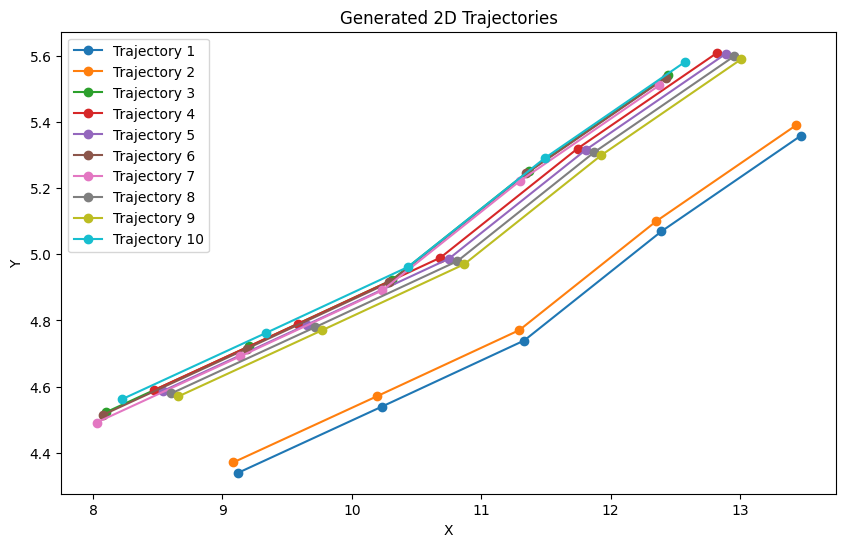

In [1]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from scipy.stats import norm
import matplotlib.pyplot as plt

class Generator:
    """
    Mock generator for generating 2D predictions based on latent variable z.
    In practice, replace this with a pre-trained model.
    """
    def predict(self, X, z):
        # Generate 2D path by simulating (x, y) points
        # Assume each point in X is a time step, and we generate a 2D path
        x_path = X[:, 0] + torch.sin(z)  # x-coordinate (example transformation)
        y_path = X[:, 1] + torch.cos(z)  # y-coordinate (example transformation)
        return torch.stack((x_path, y_path), dim=-1)  # Stack into (x, y) format

def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    """
    Radial Basis Function (RBF) kernel for 2D data.
    """
    sqdist = torch.cdist(X1, X2)**2
    return variance * torch.exp(-0.5 * sqdist / length_scale**2)

def pseudo_score(generator, X, z, z_mode):
    """
    Compute the pseudo-score for a latent variable z.
    """
    Y_hat = generator.predict(X, z)
    Y_mode = generator.predict(X, z_mode)
    score = -torch.mean(torch.norm(Y_hat - Y_mode, dim=-1))  # negative distance as pseudo-score
    return score.item()

def warmup(generator, X, w, latent_dim):
    """
    Generate initial samples using Monte Carlo sampling.
    """
    z_samples = torch.randn(w, latent_dim)
    scores = []
    for z in z_samples:
        score = pseudo_score(generator, X, z, z_mode=torch.zeros(latent_dim))
        scores.append(score)
    return z_samples, torch.tensor(scores)

def fit_gp_model(z_samples, scores, length_scale=1.0, variance=1.0, noise=1e-6):
    """
    Fit a Gaussian Process model to the data.
    """
    K = rbf_kernel(z_samples, z_samples, length_scale, variance) + noise**2 * torch.eye(len(z_samples))
    jitter = 1e-6
    K = K + jitter * torch.eye(K.size(0))  # Add small jitter to the diagonal to avoid singular matrix (un-inversable)

    K_inv = torch.inverse(K)
    gp_model = {
        'K': K,
        'K_inv': K_inv,
        'z_train': z_samples,
        'y_train': scores,
        'length_scale': length_scale,
        'variance': variance,
        'noise': noise
    }
    return gp_model

def gp_predict(gp_model, z_candidate):
    """
    Predict mean and variance at z_candidate using GP model.
    """
    K = gp_model['K']
    jitter = 1e-6
    K = K + jitter * torch.eye(K.size(0))  # Add small jitter to the diagonal

    K_inv = gp_model['K_inv']
    z_train = gp_model['z_train']
    y_train = gp_model['y_train']
    length_scale = gp_model['length_scale']
    variance = gp_model['variance']
    noise = gp_model['noise']

    K_s = rbf_kernel(z_train, z_candidate.unsqueeze(0), length_scale, variance)
    K_ss = rbf_kernel(z_candidate.unsqueeze(0), z_candidate.unsqueeze(0), length_scale, variance) + noise**2 * torch.eye(1)

    mu_s = K_s.t().matmul(K_inv).matmul(y_train)
    cov_s = K_ss - K_s.t().matmul(K_inv).matmul(K_s)
    sigma_s = torch.sqrt(cov_s + 1e-8)

    # Ensure mu and sigma are tensors with requires_grad
    mu = mu_s.clone().detach().requires_grad_(True)
    sigma = sigma_s.clone().detach().requires_grad_(True)
    return mu, sigma
    # return mu_s.item(), sigma_s.item()

def acquisition_function(z_candidate, gp_model, beta):
    """
    Compute the acquisition value for a candidate z.
    """
    mu, sigma = gp_predict(gp_model, z_candidate)
    acq_value = mu + beta * sigma
    # print('acq_value:', acq_value)
    return torch.tensor(acq_value, requires_grad=True)

def optimize_acquisition_function(gp_model, latent_dim, beta, num_iter=50, lr=0.1):
    """
    Optimize the acquisition function to find the next z.
    """
    z_candidate = torch.randn(latent_dim, requires_grad=True)
    optimizer = Adam([z_candidate], lr=lr)
    for _ in range(num_iter):
        optimizer.zero_grad()

        acq_value = -acquisition_function(z_candidate, gp_model, beta)
        if not acq_value.requires_grad:
            raise RuntimeError("acquisition function returned a tensor without requires_grad!")
        
        acq_value.backward()
        optimizer.step()
    return z_candidate.detach()

def BOsampler(generator, X, N, w, latent_dim, beta):
    """
    Perform BO sampling to generate N trajectories.
    """
    # Warm-up stage
    z_samples, scores = warmup(generator, X, w, latent_dim)
    trajectories = [generator.predict(X, z) for z in z_samples]

    for n in range(w, N):
        # Fit GP model
        gp_model = fit_gp_model(z_samples, scores)

        # Optimize acquisition function to get next z
        z_next = optimize_acquisition_function(gp_model, latent_dim, beta)

        # Generate trajectory and compute pseudo-score
        score_next = pseudo_score(generator, X, z_next, z_mode=torch.zeros(latent_dim))

        # Update samples and scores
        z_samples = torch.vstack([z_samples, z_next.unsqueeze(0)])
        scores = torch.cat([scores, torch.tensor([score_next])])
        trajectories.append(generator.predict(X, z_next))

    return trajectories

# Example usage
if __name__ == "__main__":
    generator = Generator()

    t1 = [(8.46, 3.59), (9.57, 3.79), (10.67, 3.99), (11.73, 4.32), (12.81, 4.61)]
    t2 = [13.64, 5.8, 12.09, 5.75, 11.37, 5.8, 10.31, 5.97, 9.57, 6.24, 8.73, 6.34, 7.94, 6.5, 7.17, 6.62, 6.47, 6.68, 5.86, 6.82, 5.24, 6.98, 4.87, 7.16, 4.51, 7.58, 4.2, 7.3]
    t2 = list(zip(t2[::2], t2[1::2]))
    
    X = torch.tensor(t1)  # Example observed trajectory points
    N = 10          # Total number of samples
    w = 3          # Number of warm-up samples
    latent_dim = 1  # Dimension of latent variable z
    beta = 0.5      # Exploration-exploitation trade-off

    trajectories = BOsampler(generator, X, N, w, latent_dim, beta)

    # Plot results
    plt.figure(figsize=(10, 6))
    for idx, traj in enumerate(trajectories):
        traj_np = traj.detach().numpy()
        plt.plot(traj_np[:, 0], traj_np[:, 1], marker='o', label=f'Trajectory {idx + 1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Generated 2D Trajectories')
    plt.legend()
    plt.show()


In [19]:
g=Generator()

t1 = [(8.46, 3.59), (9.57, 3.79), (10.67, 3.99), (11.73, 4.32), (12.81, 4.61)]
X = torch.tensor(t1) 

g.predict(X, torch.tensor(0.5))

tensor([[ 8.9394,  4.4676],
        [10.0494,  4.6676],
        [11.1494,  4.8676],
        [12.2094,  5.1976],
        [13.2894,  5.4876]])

# PECNET

In [112]:
# Baseline model for "It is Not the Journey but the Destination: Endpoint Conditioned Trajectory Prediction"
# Source-code directly referred from PECNet at https://github.com/HarshayuGirase/Human-Path-Prediction/blob/master/PECNet/utils/models.py

import torch
import torch.nn as nn
from torch.autograd import Variable
import random
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import pdb
from torch.nn import functional as F
from torch.distributions.normal import Normal
import math
import numpy as np
import yaml

'''MLP model'''
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=(1024, 512), activation='relu', discrim=False, dropout=-1):
        super(MLP, self).__init__()
        dims = []
        dims.append(input_dim)
        dims.extend(hidden_size)
        dims.append(output_dim)
        self.layers = nn.ModuleList()
        for i in range(len(dims)-1):
            self.layers.append(nn.Linear(dims[i], dims[i+1]))

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

        self.sigmoid = nn.Sigmoid() if discrim else None
        self.dropout = dropout

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if i != len(self.layers)-1:
                x = self.activation(x)
                if self.dropout != -1:
                    x = nn.Dropout(min(0.1, self.dropout/3) if i == 1 else self.dropout)(x)
            elif self.sigmoid:
                x = self.sigmoid(x)
        return x

class PECNet(nn.Module):

    def __init__(self, enc_past_size, enc_dest_size, enc_latent_size, dec_size, predictor_size, non_local_theta_size, non_local_phi_size, non_local_g_size, fdim, zdim, nonlocal_pools, non_local_dim, sigma, past_length, future_length, verbose):
        '''
        Args:
            size parameters: Dimension sizes
            nonlocal_pools: Number of nonlocal pooling operations to be performed
            sigma: Standard deviation used for sampling N(0, sigma)
            past_length: Length of past history (number of timesteps)
            future_length: Length of future trajectory to be predicted
        '''
        super(PECNet, self).__init__()

        self.zdim = zdim
        self.nonlocal_pools = nonlocal_pools
        self.sigma = sigma

        # takes in the past
        self.encoder_past = MLP(input_dim = past_length*2, output_dim = fdim, hidden_size=enc_past_size)

        self.encoder_dest = MLP(input_dim = 2, output_dim = fdim, hidden_size=enc_dest_size)

        self.encoder_latent = MLP(input_dim = 2*fdim, output_dim = 2*zdim, hidden_size=enc_latent_size)

        self.decoder = MLP(input_dim = fdim + zdim, output_dim = 2, hidden_size=dec_size)

        self.non_local_theta = MLP(input_dim = 2*fdim + 2, output_dim = non_local_dim, hidden_size=non_local_theta_size)
        self.non_local_phi = MLP(input_dim = 2*fdim + 2, output_dim = non_local_dim, hidden_size=non_local_phi_size)
        self.non_local_g = MLP(input_dim = 2*fdim + 2, output_dim = 2*fdim + 2, hidden_size=non_local_g_size)

        self.predictor = MLP(input_dim = 2*fdim + 2, output_dim = 2*(future_length-1), hidden_size=predictor_size)

        architecture = lambda net: [l.in_features for l in net.layers] + [net.layers[-1].out_features]

        if verbose:
            print("Past Encoder architecture : {}".format(architecture(self.encoder_past)))
            print("Dest Encoder architecture : {}".format(architecture(self.encoder_dest)))
            print("Latent Encoder architecture : {}".format(architecture(self.encoder_latent)))
            print("Decoder architecture : {}".format(architecture(self.decoder)))
            print("Predictor architecture : {}".format(architecture(self.predictor)))

            print("Non Local Theta architecture : {}".format(architecture(self.non_local_theta)))
            print("Non Local Phi architecture : {}".format(architecture(self.non_local_phi)))
            print("Non Local g architecture : {}".format(architecture(self.non_local_g)))

    def non_local_social_pooling(self, feat, mask):

        # N,C
        theta_x = self.non_local_theta(feat)

        # C,N
        phi_x = self.non_local_phi(feat).transpose(1,0)

        # f_ij = (theta_i)^T(phi_j), (N,N)
        f = torch.matmul(theta_x, phi_x)

        # f_weights_i =  exp(f_ij)/(\sum_{j=1}^N exp(f_ij))
        f_weights = F.softmax(f, dim = -1)

        # setting weights of non neighbours to zero
        f_weights = f_weights * mask

        # rescaling row weights to 1
        f_weights = F.normalize(f_weights, p=1, dim=1)

        # ith row of all_pooled_f = \sum_{j=1}^N f_weights_i_j * g_row_j
        pooled_f = torch.matmul(f_weights, self.non_local_g(feat))

        return pooled_f + feat

    def forward(self, x, initial_pos, dest = None, mask = None, device=torch.device('cpu'), noise=None):

        # provide destination iff training
        # assert model.training
        assert self.training ^ (dest is None)
        assert self.training ^ (mask is None)

        # encode
        ftraj = self.encoder_past(x)

        if not self.training:
            if noise is not None:
                z = noise * self.sigma
            else:
                z = torch.Tensor(x.size(0), self.zdim)
                z.normal_(0, self.sigma)

        else:
            # during training, use the destination to produce generated_dest and use it again to predict final future points

            # CVAE code
            dest_features = self.encoder_dest(dest)
            features = torch.cat((ftraj, dest_features), dim = 1)
            latent =  self.encoder_latent(features)

            mu = latent[:, 0:self.zdim] # 2-d array
            logvar = latent[:, self.zdim:] # 2-d array

            var = logvar.mul(0.5).exp_()
            eps = torch.FloatTensor(var.size()).normal_()
            eps = eps.to(device)
            z = eps.mul(var).add_(mu)

        z = z.to(device)
        decoder_input = torch.cat((ftraj, z), dim = 1)
        generated_dest = self.decoder(decoder_input)

        if self.training:
            # prediction in training, no best selection
            generated_dest_features = self.encoder_dest(generated_dest)

            prediction_features = torch.cat((ftraj, generated_dest_features, initial_pos), dim = 1)

            for i in range(self.nonlocal_pools):
                # non local social pooling
                prediction_features = self.non_local_social_pooling(prediction_features, mask)

            pred_future = self.predictor(prediction_features)
            return generated_dest, mu, logvar, pred_future

        return generated_dest

    # separated for forward to let choose the best destination
    def predict(self, past, generated_dest, mask, initial_pos):
        ftraj = self.encoder_past(past)
        generated_dest_features = self.encoder_dest(generated_dest)
        prediction_features = torch.cat((ftraj, generated_dest_features, initial_pos), dim = 1)

        for i in range(self.nonlocal_pools):
            # non local social pooling
            prediction_features = self.non_local_social_pooling(prediction_features, mask)

        interpolated_future = self.predictor(prediction_features)
        return interpolated_future

In [3]:
class ConfigExtractor():
    def __init__(self,file_path) -> None:
        self.file_path = file_path
        with open(file_path, 'r') as stream:
            self.data = yaml.safe_load(stream)
    
    def __str__(self) -> str:
        return str(self.data)

    def __call__(self, ) -> dict:
        return self.data

class LoadModel():
    def __init__(self,model_name,model_weight,) -> None:
        self.model_name = model_name
        self.model_weight = model_weight
    def load(self,):
        if self.model_name == 'pecnet':
            def get_hyperparams():
                global data_scale
                with open("./configs/pecnet/optimal_settings.yaml", 'r') as file:
                    hyper_params = yaml.load(file, Loader=yaml.FullLoader)
                    data_scale = hyper_params["data_scale"]
                    return (hyper_params["enc_past_size"], hyper_params["enc_dest_size"], hyper_params["enc_latent_size"],
                            hyper_params["dec_size"], hyper_params["predictor_hidden_size"], hyper_params['non_local_theta_size'],
                            hyper_params['non_local_phi_size'], hyper_params['non_local_g_size'], hyper_params["fdim"],
                            hyper_params["zdim"], hyper_params["nonlocal_pools"], hyper_params['non_local_dim'],
                            hyper_params["sigma"], hyper_params["past_length"], hyper_params["future_length"], False)
            model = PECNet(*get_hyperparams())

            # For CPU
            model.load_state_dict(torch.load(self.model_weight, map_location=torch.device('cpu')))
            model = model.cpu()
            
            # For GPU
            # model.load_state_dict(torch.load(self.model_weight))
            # model = model.cuda()

            model.eval()
            return model
        else:
            raise NotImplementedError

In [13]:
configs = ConfigExtractor(r"configs\pecnet\bo.yaml")()

model_name = configs['model_name']
model_path = configs['model_path'][0]

m = LoadModel(model_name=model_name,model_weight=model_path,)
model = m.load()

### Fake Data

In [36]:
import torch

configs = ConfigExtractor(r"configs\pecnet\bo.yaml")()

# Load the model weights and create a PECNet instance
model_name = configs['model_name']
model_weight_path = configs['model_path'][0]  # update with your actual path
model_loader = LoadModel(model_name=model_name, model_weight=model_weight_path)
model = model_loader.load()

# Prepare sample input data
past_trajectories = torch.rand(10, 16)  # Example: 10 samples with 16 features (past_length * 2)
initial_positions = torch.rand(10, 2)   # Initial positions for each sample (10 samples, x and y coordinates)

#  Create a mask tensor filled with ones, assuming no neighborhood restrictions
mask = torch.ones(10, 10)  # Replace 10 with the number of samples in past_trajectories

# Ensure model is in evaluation mode for inference
model.eval()

# Perform prediction
with torch.no_grad():
    generated_dest = model(past_trajectories, initial_positions)
    predicted_trajectory = model.predict(past_trajectories, generated_dest, mask=mask, initial_pos=initial_positions)

print("Generated Destination:", generated_dest)
print("Predicted Future Trajectory:", predicted_trajectory)

Generated Destination: tensor([[  2.8903,  -1.9012],
        [-24.6942, -12.2786],
        [  4.4269,  -0.4275],
        [  4.6481,   1.3057],
        [  8.4005,   0.3474],
        [ -1.2960,  -4.5178],
        [ 14.1292,  10.8279],
        [  6.0689,  -7.6349],
        [ -2.9840,  -1.9476],
        [  3.9513,   0.9513]])
Predicted Future Trajectory: tensor([[ -1.1688,   1.1509,  -0.3803,   0.2790,  -0.2952,  -0.3866,  -0.2474,
          -1.7910,  -0.6637,  -2.0124,   0.2508,  -2.3119,   0.1897,  -2.8681,
           0.5072,  -2.6693,   1.0869,  -2.1804,   2.1569,  -0.8265,   3.2368,
          -0.6434],
        [ -2.4791,   1.0732,  -2.6539,   1.0382,  -2.8707,   1.4721,  -3.9781,
           2.0106,  -4.5153,   2.3093,  -5.1330,   2.2384,  -5.5639,   2.1113,
          -6.6021,   1.7953,  -7.5444,   1.6619,  -9.1483,   1.8316, -10.2534,
           0.8166],
        [ -1.1095,   1.4419,  -0.1082,  -0.0353,  -0.3111,  -0.5035,  -0.4739,
          -2.1401,  -1.2563,  -2.6454,  -0.5778,  -3.0

### Real Data

In [1]:
import torch

configs = ConfigExtractor(r"configs\pecnet\bo.yaml")()

# Load the model weights and create a PECNet instance
model_name = configs['model_name']
model_weight_path = configs['model_path'][0]  # update with your actual path
model_loader = LoadModel(model_name=model_name, model_weight=model_weight_path)
model = model_loader.load()

# Example input trajectory with 5 (x, y) coordinates
# input_trajectory = [(13.64, 5.8), (12.09, 5.75), (11.37, 5.8), (10.31, 5.97), (9.57, 6.24), (8.73, 6.34), (7.94, 6.5), (7.17, 6.62), (6.47, 6.68), (5.86, 6.82), (5.24, 6.98), (4.87, 7.16), (4.51, 7.58), (4.2, 7.3)]
input_trajectory = [(13.64, 0.25577658578366214), (12.09, 0.22942764990525732), (11.37, 0.25577658578366214), (10.31, 0.3453629677702387), (9.57, 0.4876472215136254), (8.73, 0.540345093270435), (7.94, 0.6246616880813307), (7.17, 0.6878991341895025), (6.47, 0.7195178572435882), (5.86, 0.7932948777031222), (5.24, 0.8776114725140179), (4.87, 0.9724676416762754), (4.51, 1.1937987030548765), (4.2, 1.046244662135809), (3.95, 1.2623059363387292), (3.47, 1.341352743973944), (2.82, 1.4151297644334775), (2.01, 1.4151297644334775), (1.28, 1.3202735952712201), (0.54, 1.098942533892619), (-0.18, 0.9197697699194654), (-0.83, 0.5877731778515637), (-1.52, 0.3875212651756866)]

# Flatten the trajectory and pad to match the expected model input size (e.g., 16)
flattened_trajectory = torch.tensor(input_trajectory).flatten()
expected_input_size = 16  # Update if your model expects a different size

# Pad with zeros if needed
if flattened_trajectory.shape[0] < expected_input_size:
    print('MISMATCH: adding padding')
    padded_trajectory = torch.cat([flattened_trajectory, torch.zeros(expected_input_size - flattened_trajectory.shape[0])])
else:
    print('No dimension mismatch :)')
    padded_trajectory = flattened_trajectory

# Reshape to add batch dimension (1, expected_input_size)
past_trajectory_tensor = padded_trajectory[:expected_input_size].unsqueeze(0)

# Set initial position as the first point in the trajectory
initial_position_tensor = torch.tensor(input_trajectory[0]).unsqueeze(0)  # Shape: [1, 2]

# Mask tensor of ones (no neighborhood restrictions)
mask = torch.ones(1, 1)  # Shape: [1, 1]

# Model prediction
model.eval()
with torch.no_grad():
    # Generate the destination
    generated_dest = model(past_trajectory_tensor, initial_position_tensor)
    # Predict the future trajectory
    predicted_trajectory = model.predict(past_trajectory_tensor, generated_dest, mask=mask, initial_pos=initial_position_tensor)

print("Generated Destination:", generated_dest)
print("Predicted Future Trajectory:", predicted_trajectory)

NameError: name 'ConfigExtractor' is not defined

In [ ]:
t2 = [13.64, 5.8, 12.09, 5.75, 11.37, 5.8, 10.31, 5.97, 9.57, 6.24, 8.73, 6.34, 7.94, 6.5, 7.17, 6.62, 6.47, 6.68, 5.86, 6.82, 5.24, 6.98, 4.87, 7.16, 4.51, 7.58, 4.2, 7.3]
t2 = list(zip(t2[::2], t2[1::2]))
t2 = [(13.64, 5.8), (12.09, 5.75), (11.37, 5.8), (10.31, 5.97), (9.57, 6.24), (8.73, 6.34), (7.94, 6.5), (7.17, 6.62), (6.47, 6.68), (5.86, 6.82), (5.24, 6.98), (4.87, 7.16), (4.51, 7.58), (4.2, 7.3)]

[(13.64, 5.8), (12.09, 5.75), (11.37, 5.8), (10.31, 5.97), (9.57, 6.24), (8.73, 6.34), (7.94, 6.5), (7.17, 6.62), (6.47, 6.68), (5.86, 6.82), (5.24, 6.98), (4.87, 7.16), (4.51, 7.58), (4.2, 7.3)]


gg:  tensor([[-1.7472,  2.8367]])
Past Trajectory: tensor([[1.6774, 0.2558, 1.3670, 0.2294, 1.2228, 0.2558, 1.0106, 0.3454, 0.8624,
         0.4876, 0.6942, 0.5403, 0.5360, 0.6247, 0.3818, 0.6879]])
Generated Destination: tensor([[-1.7472,  2.8367]])
Predicted Future Trajectory: tensor([[-3.0601,  3.5779, -2.5466,  1.7156, -2.8525,  1.5235, -3.4990, -0.3695,
         -5.1587, -0.6671, -4.0939, -1.0269, -5.1436, -1.0282, -5.8115, -1.3380,
         -4.9382, -0.6500, -4.5796,  1.5275, -2.9044,  1.5907]])


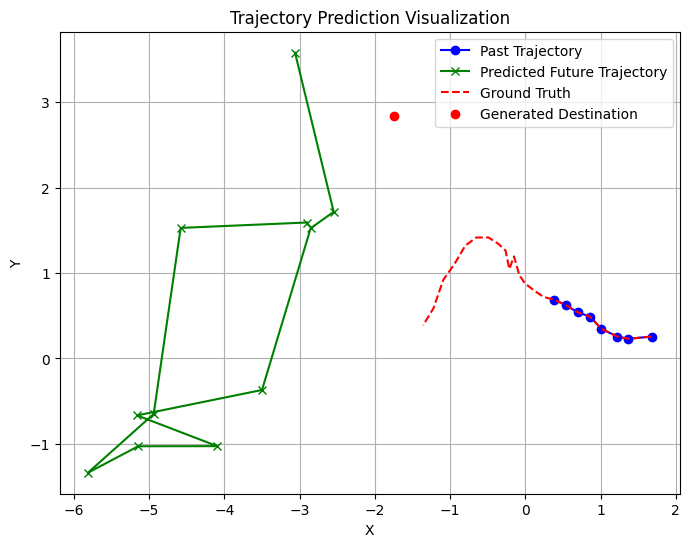

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming the model and input data have been loaded as shown in the previous code
input_trajectory = [(13.64, 5.8), (12.09, 5.75), (11.37, 5.8), (10.31, 5.97), (9.57, 6.24), 
                    (8.73, 6.34), (7.94, 6.5), (7.17, 6.62), (6.47, 6.68), (5.86, 6.82), 
                    (5.24, 6.98), (4.87, 7.16), (4.51, 7.58), (4.2, 7.3)]
input_trajectory = [(1.6774166066042866, 0.25577658578366214), (1.3670236781155147, 0.22942764990525732), (1.2228411564949235, 0.25577658578366214), (1.010572444109054, 0.3453629677702387), (0.8623848524434465, 0.4876472215136254), (0.6941719105527572, 0.540345093270435), (0.5359716437746088, 0.6246616880813307), (0.3817764470414768, 0.6878991341895025), (0.24159899546590224, 0.7195178572435882), (0.11944435909290171, 0.7932948777031222), (-0.004712812302607148, 0.8776114725140179), (-0.07880660813541084, 0.9724676416762754), (-0.15089786894570636, 1.1937987030548765), (-0.21297645464346068, 1.046244662135809), (-0.2630398302061659, 1.2623059363387292), (-0.3591615112865598, 1.341352743973944), (-0.48932628774959336, 1.4151297644334775), (-0.6515316245727582, 1.4151297644334775), (-0.7977166812158571, 1.3202735952712201), (-0.9459042728814645, 1.098942533892619), (-1.0900867945020554, 0.9197697699194654), (-1.220251570965089, 0.5877731778515637), (-1.3584264875181553, 0.3875212651756866)]
flattened_trajectory = torch.tensor(input_trajectory).flatten()
expected_input_size = 16

if flattened_trajectory.shape[0] < expected_input_size:
    padded_trajectory = torch.cat([flattened_trajectory, torch.zeros(expected_input_size - flattened_trajectory.shape[0])])
else:
    padded_trajectory = flattened_trajectory

past_trajectory_tensor = padded_trajectory[:expected_input_size].unsqueeze(0)
initial_position_tensor = torch.tensor(input_trajectory[0]).unsqueeze(0)
mask = torch.ones(1, 1)


# Model prediction
model.eval()
with torch.no_grad():
    # Generate the destination
    generated_dest = model(past_trajectory_tensor, initial_position_tensor)
    # generated_dest = torch.tensor(input_trajectory[-1]).unsqueeze(0)
    print('gg: ', generated_dest)
    # Predict the future trajectory
    predicted_trajectory = model.predict(past_trajectory_tensor, generated_dest, mask=mask, initial_pos=initial_position_tensor)

print("Past Trajectory:", past_trajectory_tensor)
print("Generated Destination:", generated_dest)
print("Predicted Future Trajectory:", predicted_trajectory)

# Convert to numpy for easy plotting
input_trajectory_np = np.array(input_trajectory)
past_trajectory_np = past_trajectory_tensor.squeeze().cpu().numpy()
predicted_trajectory_np = predicted_trajectory.squeeze().cpu().numpy()  # Convert tensor to numpy array
generated_dest_np = generated_dest.squeeze().cpu().numpy()  # Convert tensor to numpy array

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the past trajectory
plt.plot(past_trajectory_np[::2], past_trajectory_np[1::2], color='blue', label="Past Trajectory", marker='o')

# Plot the predicted future trajectory
plt.plot(predicted_trajectory_np[::2], predicted_trajectory_np[1::2], color='green', label="Predicted Future Trajectory", marker='x')

# Plot the ground truth trajectory
plt.plot(input_trajectory_np[:, 0], input_trajectory_np[:, 1], color='red', label="Ground Truth", linestyle='--')

# Plot the generated destination as a red dot
plt.scatter(generated_dest_np[0], generated_dest_np[1], color='red', label="Generated Destination", zorder=5)

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Trajectory Prediction Visualization")
plt.grid(True)
plt.show()


# Training PECNet from Scratch

In [133]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import glob

# Load data (single file)
file_path = r'src\datasets\eth\train\students001_train.txt'
pedestrian_data = pd.read_csv(file_path, sep='\t', header=None)
pedestrian_data.columns = ["Frame Number", "Pedestrian ID", "X-Coordinate", "Y-Coordinate"]

'''
# Define the file pattern for loading files
file_pattern = r'src\datasets\eth\train\*.txt'
csv_files = glob.glob(file_pattern)

# Initialize an empty list to store DataFrames
dataframes = []
max_ped_id = 0  # Track the maximum pedestrian ID used so far

# Loop over each file
for file in csv_files:
    # Load the current file into a DataFrame
    df = pd.read_csv(file, sep='\t', header=None)
    df.columns = ["Frame Number", "Pedestrian ID", "X-Coordinate", "Y-Coordinate"]
    
    # Update the Pedestrian ID column to ensure uniqueness across files (we don't want repeate IDs)
    df["Pedestrian ID"] += max_ped_id
    max_ped_id = df["Pedestrian ID"].max() + 1  # Increment by 1 to avoid overlap

    # Append the updated DataFrame to the list
    dataframes.append(df)
# Combine  all DataFrames into one
pedestrian_data = pd.concat(dataframes, ignore_index=True)
'''

# Normalize Data
scaler = StandardScaler()
pedestrian_data[['X-Coordinate', 'Y-Coordinate']] = scaler.fit_transform(
    pedestrian_data[['X-Coordinate', 'Y-Coordinate']]
)

# Check the length of the combined dataset
len(pedestrian_data)


18353

In [134]:
def get_trajectories(data, past_len=8, future_len=12):
    trajectories = []

    # Loop through each Pedestrian
    pedestrian_ids = data['Pedestrian ID'].unique()
    for pid in pedestrian_ids:
        ped_data = data[data['Pedestrian ID'] == pid]
        
        # If the trajectory is long enough
        if len(ped_data) >= past_len + future_len:
            for i in range(len(ped_data) - past_len - future_len + 1):
                X_past = ped_data.iloc[i:i+past_len][['X-Coordinate', 'Y-Coordinate']].values.flatten()
                Y_future = ped_data.iloc[i+past_len:i+past_len+future_len][['X-Coordinate', 'Y-Coordinate']].values.flatten()
                trajectories.append((X_past, Y_future))
    return trajectories

trajectories = get_trajectories(pedestrian_data)


### Train Pecnet

In [58]:
model = PECNet(enc_past_size=[128, 64], enc_dest_size=[128, 64], enc_latent_size=[128, 64],
               dec_size=[128, 64], predictor_size=[128, 64], non_local_theta_size=[128, 64],
               non_local_phi_size=[128, 64], non_local_g_size=[128, 64],
               fdim=64, zdim=8, nonlocal_pools=2, non_local_dim=128,
               sigma=1.0, past_length=8, future_length=12, verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()


epochs = 5
for epoch in range(epochs):
    total_loss = 0

    for X_past, Y_future in trajectories:
        X_past_tensor = torch.tensor(X_past).unsqueeze(0).float()
        initial_pos = X_past_tensor[:, :2]  # First coordinate as initial position
        Y_future_tensor = torch.tensor(Y_future).float()
        
        # Corrected dest to be only the last (x, y) coordinate
        dest = Y_future_tensor[-2:].unsqueeze(0)
        # print(dest)
        
        # Placeholder for mask (adjust if social pooling needed)
        mask = torch.ones((1, 1))  # Adjust dimensions based on actual needs

        # Forward pass with training mode enabled
        model.train()
        optimizer.zero_grad()
        generated_dest, mu, logvar, pred_future = model(X_past_tensor, initial_pos, dest, mask=mask)
        
        # Calculate Loss
        dest_loss = loss_fn(generated_dest, dest)
        # future_loss = loss_fn(pred_future, Y_future_tensor[:, :-1].reshape(-1, 2))
        future_loss = loss_fn(pred_future.view(-1), Y_future_tensor[:-2].view(-1))
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = dest_loss + future_loss + 0.1 * kl_loss
        total_loss.backward()
        optimizer.step()

        
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss.item()}")


Past Encoder architecture : [16, 128, 64, 64]
Dest Encoder architecture : [2, 128, 64, 64]
Latent Encoder architecture : [128, 128, 64, 16]
Decoder architecture : [72, 128, 64, 2]
Predictor architecture : [130, 128, 64, 22]
Non Local Theta architecture : [130, 128, 64, 128]
Non Local Phi architecture : [130, 128, 64, 128]
Non Local g architecture : [130, 128, 64, 130]
Epoch 1/5, Loss: 0.024527443572878838
Epoch 2/5, Loss: 0.02443288452923298
Epoch 3/5, Loss: 0.02443288452923298
Epoch 4/5, Loss: 0.02443288452923298
Epoch 5/5, Loss: 0.02443288452923298


### Predict and Visualize

Offset: (-2.615518093109131, 2.8874282836914062)


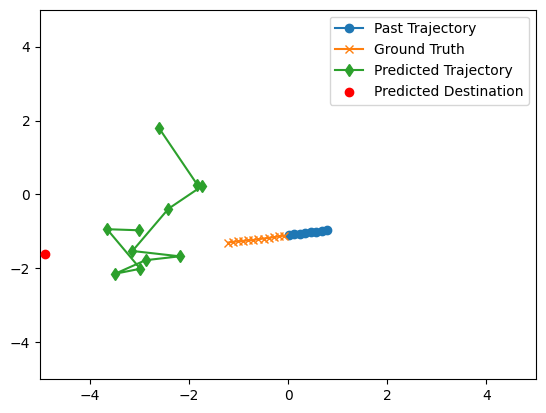

Offset: (-2.459989070892334, 2.6517691612243652)


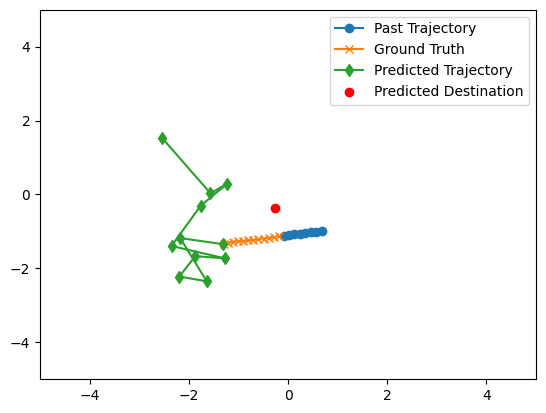

Offset: (-2.7167069911956787, 2.667809247970581)


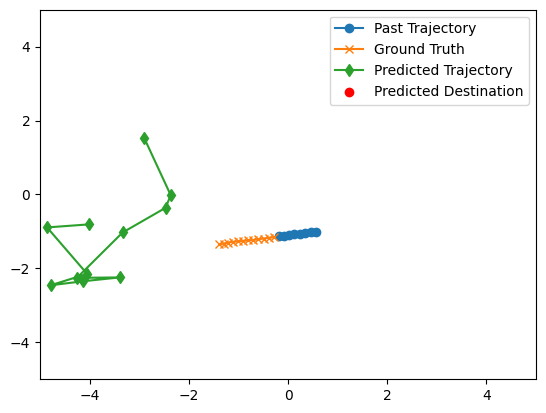

Offset: (-2.581925630569458, 2.3728830814361572)


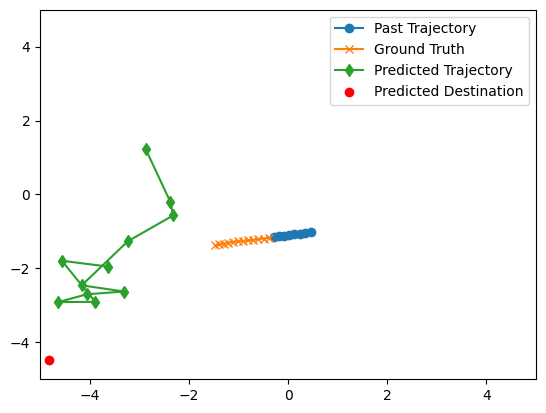

Offset: (-2.3178579807281494, 2.2320148944854736)


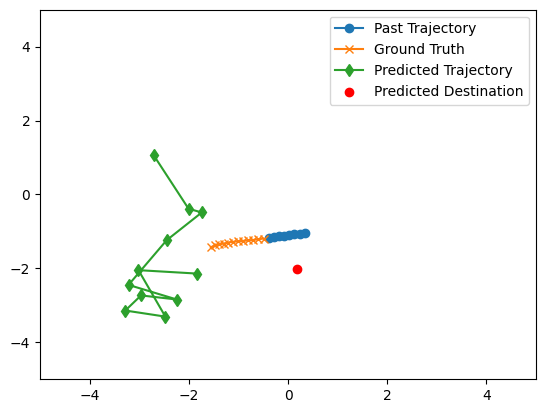

Offset: (-11.313318252563477, -10.236305236816406)


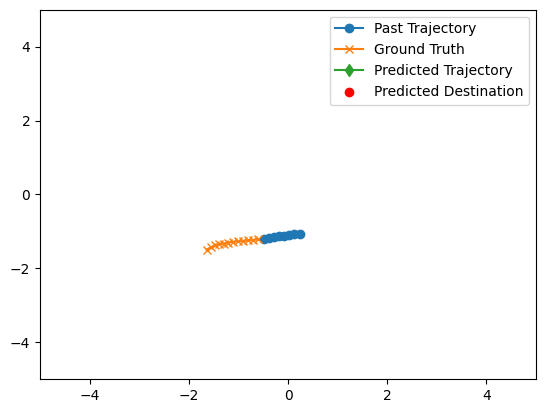

Offset: (-2.380812168121338, 2.094043731689453)


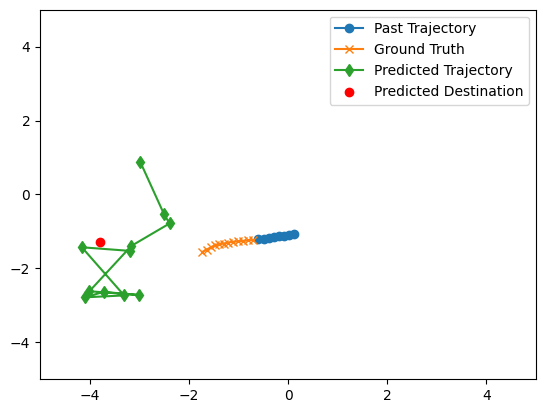

Offset: (-2.3819375038146973, 1.9886133670806885)


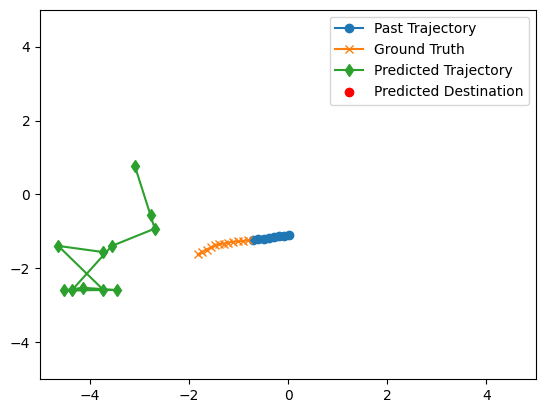

Offset: (-2.473599910736084, 1.8557777404785156)


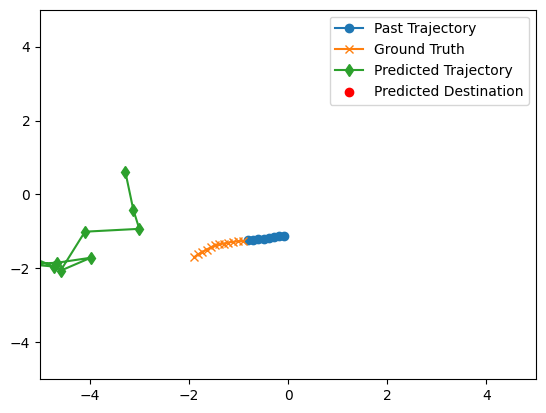

Offset: (-2.3859097957611084, 1.6176872253417969)


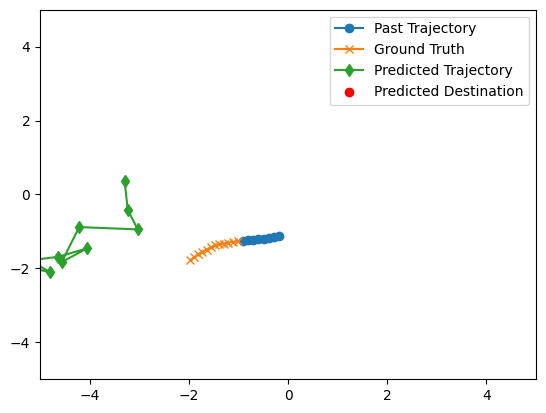

In [138]:
import matplotlib.pyplot as plt



# model = PECNet(enc_past_size=[128, 64], enc_dest_size=[128, 64], enc_latent_size=[128, 64],
#                dec_size=[128, 64], predictor_size=[128, 64], non_local_theta_size=[128, 64],
#                non_local_phi_size=[128, 64], non_local_g_size=[128, 64],
#                fdim=64, zdim=8, nonlocal_pools=2, non_local_dim=128,
#                sigma=1.0, past_length=8, future_length=12, verbose=True)
# model.load_state_dict(torch.load('pecnet_model_1.pth', map_location=torch.device('cpu')))
model = LoadModel('pecnet', r'saved_models/pecnet/eth/val_best.pth').load()


# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_fn = torch.nn.MSELoss()



X_past_arr = []
Y_future_arr = []
predicted_traj_arr = []
predicted_dest_arr = []

samples = range(10)
for i in samples:

    # Extract inputs
    X_past, Y_future = trajectories[i]  # Example trajectory
    X_past_tensor = torch.tensor(X_past).unsqueeze(0).float()
    initial_pos = X_past_tensor[:, :2]

    # Predict trajectory
    with torch.no_grad():
        model.eval()
        generated_dest = model(X_past_tensor, initial_pos)

        mask = torch.ones((1, 1))  # Adjust dimensions based on actual needs
        predicted_trajectory = model.predict(X_past_tensor, generated_dest, mask=mask, initial_pos=initial_pos)
    
    X_past_arr.append(X_past_tensor)
    Y_future_arr.append(Y_future)
    # print(f'Pred traj {i}: {predicted_trajectory}')
    predicted_traj_arr.append(predicted_trajectory)
    predicted_dest_arr.append(generated_dest)


for i in range(len(samples)):
    # Reshape for plotting
    X_past = X_past_arr[i].reshape(-1, 2).numpy()
    Y_future = torch.tensor(Y_future_arr[i]).reshape(-1, 2).numpy()
    predicted_trajectory = predicted_traj_arr[i].reshape(-1, 2).numpy()
    predicted_dest = predicted_dest_arr[i].reshape(-1, 2).numpy()  # Reshape the predicted destination

    diff_x, diff_y = predicted_trajectory[0] - X_past[-1]
    print(f'Offset: ({diff_x}, {diff_y})')
    # predicted_trajectory -= [diff_x, diff_y]

    plt.plot(X_past[:, 0], X_past[:, 1], label="Past Trajectory", marker='o')
    plt.plot(Y_future[:, 0], Y_future[:, 1], label="Ground Truth", marker='x')
    plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], label="Predicted Trajectory", marker='d')
    plt.scatter(predicted_dest[0, 0], predicted_dest[0, 1], color='red', label='Predicted Destination', zorder=5)

    plt.xlim(-5,5)
    plt.ylim(-5,5)

    plt.legend()
    plt.show()

